In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import random 
import os 
import torch 
from torch import nn  
from torch.utils.data import Dataset, DataLoader 
from sklearn.model_selection import train_test_split 
import time 
import datetime 
import json
import ccxt 
import sys

# Preprocess Data

We process data such that we predict open, high, low, close, volume at once

In [2]:
with open('BTC_USDT-1h_bybit.json') as f: 
    df = json.load(f) 
    
df = pd.DataFrame(df) 
df

,0,1,2,3,4,5
0,1585130400000,6500.0,6591.5,6500.0,6591.5,2.636600e+01
1,1585134000000,6591.5,6628.5,6457.5,6511.5,2.857722e+06
2,1585137600000,6511.5,6588.5,6502.0,6583.5,3.484765e+06
3,1585141200000,6583.5,6745.5,6562.0,6585.0,2.957732e+06
4,1585144800000,6585.0,6640.0,6516.0,6590.0,1.705696e+06
...,...,...,...,...,...,...
13870,1635062400000,60780.5,60780.5,60502.5,60585.5,7.079455e+07
13871,1635066000000,60585.5,61333.0,60536.0,60868.0,1.251390e+08
13872,1635069600000,60868.0,61141.0,60832.0,61026.0,4.401238e+07
13873,1635073200000,61026.0,61049.5,60202.0,60363.0,1.511519e+08


In [3]:
dates = df[0].values 
bybit = ccxt.bybit() 
timestamp = [] 
for i in range(len(dates)): 
    date_string = bybit.iso8601(int(dates[i]))  
    date_string = date_string[:10] + " " + date_string[11:-5] 
    timestamp.append(date_string) 
    
df['timestamp'] = timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,0,1,2,3,4,5,timestamp
0,1585130400000,6500.0,6591.5,6500.0,6591.5,2.636600e+01,2020-03-25 10:00:00
1,1585134000000,6591.5,6628.5,6457.5,6511.5,2.857722e+06,2020-03-25 11:00:00
2,1585137600000,6511.5,6588.5,6502.0,6583.5,3.484765e+06,2020-03-25 12:00:00
3,1585141200000,6583.5,6745.5,6562.0,6585.0,2.957732e+06,2020-03-25 13:00:00
4,1585144800000,6585.0,6640.0,6516.0,6590.0,1.705696e+06,2020-03-25 14:00:00


In [4]:
df['year'] = df['timestamp'].dt.year 
df['month'] = df['timestamp'].dt.month 
df['day'] = df['timestamp'].dt.day 
df['weekday'] = df['timestamp'].dt.weekday 
df['hour'] = df['timestamp'].dt.hour

In [5]:
df.head()

,0,1,2,3,4,5,timestamp,year,month,day,weekday,hour
0,1585130400000,6500.0,6591.5,6500.0,6591.5,2.636600e+01,2020-03-25 10:00:00,2020,3,25,2,10
1,1585134000000,6591.5,6628.5,6457.5,6511.5,2.857722e+06,2020-03-25 11:00:00,2020,3,25,2,11
2,1585137600000,6511.5,6588.5,6502.0,6583.5,3.484765e+06,2020-03-25 12:00:00,2020,3,25,2,12
3,1585141200000,6583.5,6745.5,6562.0,6585.0,2.957732e+06,2020-03-25 13:00:00,2020,3,25,2,13
4,1585144800000,6585.0,6640.0,6516.0,6590.0,1.705696e+06,2020-03-25 14:00:00,2020,3,25,2,14


In [6]:
window_size = 20 
future_size = 1 
enc_inputs = [] 
dec_inputs = [] 
targets = [] 
enc_marks = [] 
dec_marks = [] 

for i in tqdm(range(df.shape[0] - window_size - future_size), position=0, leave=True):  
    ### get enc_inputs, dec_inputs and targets ### 
    o = df[1].values[i:i+window_size+future_size] 
    h = df[2].values[i:i+window_size+future_size] 
    l = df[3].values[i:i+window_size+future_size] 
    c = df[4].values[i:i+window_size+future_size] 
    v = df[5].values[i:i+window_size+future_size] 
    
    o = (o - np.min(o)) / (np.max(o) - np.min(o)) 
    h = (h - np.min(h)) / (np.max(h) - np.min(h)) 
    l = (l - np.min(l)) / (np.max(l) - np.min(l)) 
    c = (c - np.min(c)) / (np.max(c) - np.min(c)) 
    v = v / np.max(v)  
    
    o_train = o[:window_size].reshape((-1,1)) 
    o_target = o[-1].reshape((-1,1)) 
    h_train = h[:window_size].reshape((-1,1))
    h_target = h[-1].reshape((-1,1)) 
    l_train = l[:window_size].reshape((-1,1)) 
    l_target = l[-1].reshape((-1,1)) 
    c_train = c[:window_size].reshape((-1,1)) 
    c_target = c[-1].reshape((-1,1)) 
    v_train = v[:window_size].reshape((-1,1)) 
    v_target = v[-1].reshape((-1,1)) 
    
    x = np.concatenate([o_train,h_train,l_train,c_train,v_train],axis=1) 
    y = np.concatenate([o_target,h_target,l_target,c_target,v_target],axis=1)
    y0 = np.zeros((1,5)) 

    enc_inputs.append(x) 
    dec_inputs.append(np.concatenate([x,y0], axis = 0)) 
    targets.append(y)  
    
    month = df['month'].values[i:i+window_size+future_size].reshape((-1,1)) 
    day = df['day'].values[i:i+window_size+future_size].reshape((-1,1))
    weekday = df['weekday'].values[i:i+window_size+future_size].reshape((-1,1))
    hour = df['hour'].values[i:i+window_size+future_size].reshape((-1,1))
        
    enc_dates = np.concatenate([month[:-1,:], day[:-1,:], weekday[:-1,:], hour[:-1,:]], axis=1)  
    enc_marks.append(enc_dates) 
    
    dec_dates = np.concatenate([month, day, weekday, hour], axis=1) 
    dec_marks.append(dec_dates)
    

100%|██████████| 13854/13854 [00:02<00:00, 4669.28it/s]


In [7]:
enc_inputs = np.array(enc_inputs)
dec_inputs = np.array(dec_inputs)
targets = np.array(targets) 
enc_marks = np.array(enc_marks) 
dec_marks = np.array(dec_marks)


enc_inputs.shape, dec_inputs.shape, targets.shape, enc_marks.shape, dec_marks.shape

((13854, 20, 5), (13854, 21, 5), (13854, 1, 5), (13854, 20, 4), (13854, 21, 4))

# DataLoader

In [8]:
class CustomDataset(Dataset): 
    def __init__(self, encoder_input, decoder_input, target_input, encoder_marks, decoder_marks): 
        self.encoder_input = encoder_input 
        self.decoder_input = decoder_input 
        self.target_input = target_input 
        self.encoder_marks = encoder_marks 
        self.decoder_marks = decoder_marks 
    
    def __len__(self): 
        return len(self.encoder_input) 
    
    def __getitem__(self, i): 
        return {
            'encoder_input': torch.tensor(self.encoder_input[i], dtype=torch.float32), 
            'decoder_input': torch.tensor(self.decoder_input[i], dtype=torch.float32), 
            'target': torch.tensor(self.target_input[i], dtype=torch.float32),  
            'encoder_marks': torch.tensor(self.encoder_marks[i], dtype=torch.float32), 
            'decoder_marks': torch.tensor(self.decoder_marks[i], dtype=torch.float32) 
        }

In [9]:
train_enc_inputs, val_enc_inputs, train_dec_inputs, val_dec_inputs = train_test_split(enc_inputs, 
                                                                                      dec_inputs, 
                                                                                      random_state = 888, 
                                                                                      test_size = 0.1)  

train_targets, val_targets, _, _ = train_test_split(targets, 
                                                    dec_inputs, 
                                                    random_state = 888, 
                                                    test_size = 0.1) 


train_enc_marks, val_enc_marks, _, _ = train_test_split(enc_marks, 
                                                        dec_inputs, 
                                                        random_state = 888, 
                                                        test_size = 0.1)

train_dec_marks, val_dec_marks, _, _ = train_test_split(dec_marks, 
                                                        dec_inputs, 
                                                        random_state = 888, 
                                                        test_size = 0.1)


train_enc_inputs.shape, val_enc_inputs.shape, train_dec_inputs.shape, val_dec_inputs.shape, train_targets.shape, val_targets.shape, train_enc_marks.shape, val_enc_marks.shape, train_dec_marks.shape, val_dec_marks.shape


((12468, 20, 5),
 (1386, 20, 5),
 (12468, 21, 5),
 (1386, 21, 5),
 (12468, 1, 5),
 (1386, 1, 5),
 (12468, 20, 4),
 (1386, 20, 4),
 (12468, 21, 4),
 (1386, 21, 4))

In [10]:
BATCH_SIZE = 32 

train_dataset = CustomDataset(train_enc_inputs, 
                              train_dec_inputs, 
                              train_targets, 
                              train_enc_marks,
                              train_dec_marks)

val_dataset = CustomDataset(val_enc_inputs, 
                            val_dec_inputs, 
                            val_targets, 
                            val_enc_marks,
                            val_dec_marks) 

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True) 
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)


# Modeling

In [11]:
if not 'Informer2020' in sys.path: 
    sys.path += ["Informer2020"]

In [12]:
from Informer2020.models.model import Informer, InformerStack 

model = InformerStack(enc_in = 5, # encoder input size 
                      dec_in = 5, # decoder input size 
                      c_out = 5, # output size  
                      seq_len = window_size, # encoder sequence length 
                      label_len = window_size, # starter token length 
                      out_len = future_size, # output sequence length 
                      attn = 'prob') # use probsparse attention 

model.cuda()

InformerStack(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(5, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (hour_embed): FixedEmbedding(
        (emb): Embedding(24, 512)
      )
      (weekday_embed): FixedEmbedding(
        (emb): Embedding(7, 512)
      )
      (day_embed): FixedEmbedding(
        (emb): Embedding(32, 512)
      )
      (month_embed): FixedEmbedding(
        (emb): Embedding(13, 512)
      )
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(5, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (hour_embed): FixedEmbedding(
        (emb): Embedding(24, 512

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 
criterion = nn.MSELoss()  

In [14]:
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [15]:
device = torch.device('cuda:0')
epochs = 50 
model.zero_grad() 

# for reproducibility 
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

train_losses, val_losses = [], [] 

for epoch_i in range(0, epochs): 
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time() 
    total_loss = 0 
    model.train() 
    
    for step, batch in enumerate(train_dataloader):  
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            print('  current average loss = {}'.format(total_loss / step))
            
        encoder_input = batch['encoder_input'].to(device) 
        decoder_input = batch['decoder_input'].to(device) 
        target = batch['target'].to(device) 
        enc_marks = batch['encoder_marks'].to(device)  
        dec_marks = batch['decoder_marks'].to(device) 
        
        with torch.cuda.amp.autocast(): 
            output = model(x_enc=encoder_input,
                           x_mark_enc=enc_marks, 
                           x_dec=decoder_input, 
                           x_mark_dec=dec_marks) 
            loss = criterion(output, target) 
            total_loss += loss.item() 
            loss.backward() 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step() 
            # gradient initialization 
            model.zero_grad() 
    
    avg_train_loss = total_loss / len(train_dataloader)  
    train_losses.append(avg_train_loss)
    print("")
    print("  Average training loss: {}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        

    # ========================================
    #               Validation
    # ========================================
    
    print("")
    print("Running Validation...")
    t0 = time.time() 
    model.eval() 
    eval_loss = 0 
    for batch in val_dataloader: 
        encoder_input = batch['encoder_input'].to(device) 
        decoder_input = batch['decoder_input'].to(device) 
        target = batch['target'].to(device) 
        enc_marks = batch['encoder_marks'].to(device)  
        dec_marks = batch['decoder_marks'].to(device)   
        
        with torch.no_grad(): 
            outputs = model(x_enc=encoder_input,
                            x_mark_enc=enc_marks, 
                            x_dec=decoder_input, 
                            x_mark_dec=dec_marks) 
            loss = criterion(outputs, target) 
            eval_loss += loss.item()  
        
    avg_val_loss = eval_loss / len(val_dataloader) 
    val_losses.append(avg_val_loss) 
    print("")
    print("  Average validation loss: {}".format(avg_val_loss))
    print("  Validation epoch took: {:}".format(format_time(time.time() - t0))) 
        
    if np.min(val_losses) == val_losses[-1]: 
        print("Saving Best Checkpoint....")
        torch.save(model.state_dict(), "btc_informer_stack_" + str(epoch_i + 1) + "_val_loss_" + str(val_losses[-1])) 

        
        
print("")
print("Training Complete!")



======== Epoch 1 / 50 ========
Training...
  Batch    10  of    390.    Elapsed: 0:00:01.
  current average loss = 0.19750359952449797
  Batch    20  of    390.    Elapsed: 0:00:03.
  current average loss = 0.14759226180613041
  Batch    30  of    390.    Elapsed: 0:00:04.
  current average loss = 0.1250657598177592
  Batch    40  of    390.    Elapsed: 0:00:05.
  current average loss = 0.11138679319992661
  Batch    50  of    390.    Elapsed: 0:00:06.
  current average loss = 0.09914748154580594
  Batch    60  of    390.    Elapsed: 0:00:07.
  current average loss = 0.09198454711586238
  Batch    70  of    390.    Elapsed: 0:00:08.
  current average loss = 0.08674550301262311
  Batch    80  of    390.    Elapsed: 0:00:10.
  current average loss = 0.0822557876817882
  Batch    90  of    390.    Elapsed: 0:00:11.
  current average loss = 0.07848952615426646
  Batch   100  of    390.    Elapsed: 0:00:12.
  current average loss = 0.07433762829750776
  Batch   110  of    390.    Elapsed: 

  Batch    90  of    390.    Elapsed: 0:00:10.
  current average loss = 0.021347228520446352
  Batch   100  of    390.    Elapsed: 0:00:11.
  current average loss = 0.020952873509377242
  Batch   110  of    390.    Elapsed: 0:00:12.
  current average loss = 0.020910264754837208
  Batch   120  of    390.    Elapsed: 0:00:13.
  current average loss = 0.02061233331914991
  Batch   130  of    390.    Elapsed: 0:00:14.
  current average loss = 0.02078791971390064
  Batch   140  of    390.    Elapsed: 0:00:15.
  current average loss = 0.02071778207485165
  Batch   150  of    390.    Elapsed: 0:00:16.
  current average loss = 0.020549284319082897
  Batch   160  of    390.    Elapsed: 0:00:17.
  current average loss = 0.020464512764010578
  Batch   170  of    390.    Elapsed: 0:00:18.
  current average loss = 0.02045847678776173
  Batch   180  of    390.    Elapsed: 0:00:20.
  current average loss = 0.020438716891739102
  Batch   190  of    390.    Elapsed: 0:00:21.
  current average loss = 0.

  Batch   160  of    390.    Elapsed: 0:00:18.
  current average loss = 0.018102742469636723
  Batch   170  of    390.    Elapsed: 0:00:19.
  current average loss = 0.01806023398085552
  Batch   180  of    390.    Elapsed: 0:00:20.
  current average loss = 0.01793889740171532
  Batch   190  of    390.    Elapsed: 0:00:21.
  current average loss = 0.01790568567812443
  Batch   200  of    390.    Elapsed: 0:00:22.
  current average loss = 0.01783025567419827
  Batch   210  of    390.    Elapsed: 0:00:23.
  current average loss = 0.01789565482398584
  Batch   220  of    390.    Elapsed: 0:00:24.
  current average loss = 0.017915241606533527
  Batch   230  of    390.    Elapsed: 0:00:25.
  current average loss = 0.01781096244635789
  Batch   240  of    390.    Elapsed: 0:00:26.
  current average loss = 0.017666511573285484
  Batch   250  of    390.    Elapsed: 0:00:27.
  current average loss = 0.0177568713221699
  Batch   260  of    390.    Elapsed: 0:00:29.
  current average loss = 0.0177

  Batch   230  of    390.    Elapsed: 0:00:26.
  current average loss = 0.016862869197907655
  Batch   240  of    390.    Elapsed: 0:00:27.
  current average loss = 0.016732582403346897
  Batch   250  of    390.    Elapsed: 0:00:28.
  current average loss = 0.016623030927032233
  Batch   260  of    390.    Elapsed: 0:00:29.
  current average loss = 0.016473162707944328
  Batch   270  of    390.    Elapsed: 0:00:30.
  current average loss = 0.016416000598972594
  Batch   280  of    390.    Elapsed: 0:00:31.
  current average loss = 0.016321265747371527
  Batch   290  of    390.    Elapsed: 0:00:32.
  current average loss = 0.016291114973739303
  Batch   300  of    390.    Elapsed: 0:00:34.
  current average loss = 0.016234052336464324
  Batch   310  of    390.    Elapsed: 0:00:35.
  current average loss = 0.016241097735661653
  Batch   320  of    390.    Elapsed: 0:00:36.
  current average loss = 0.016283362478134222
  Batch   330  of    390.    Elapsed: 0:00:37.
  current average loss 

  Batch   310  of    390.    Elapsed: 0:00:32.
  current average loss = 0.014694079059746958
  Batch   320  of    390.    Elapsed: 0:00:33.
  current average loss = 0.01464934230898507
  Batch   330  of    390.    Elapsed: 0:00:35.
  current average loss = 0.014672803607853975
  Batch   340  of    390.    Elapsed: 0:00:36.
  current average loss = 0.0146889626788085
  Batch   350  of    390.    Elapsed: 0:00:37.
  current average loss = 0.014687942157366445
  Batch   360  of    390.    Elapsed: 0:00:38.
  current average loss = 0.014637714514457103
  Batch   370  of    390.    Elapsed: 0:00:39.
  current average loss = 0.014591169851907605
  Batch   380  of    390.    Elapsed: 0:00:40.
  current average loss = 0.014595113996122228

  Average training loss: 0.014588398837412779
  Training epoch took: 0:00:41

Running Validation...

  Average validation loss: 0.016087150455198505
  Validation epoch took: 0:00:01

======== Epoch 10 / 50 ========
Training...
  Batch    10  of    390.    El


  Average training loss: 0.013667100796905848
  Training epoch took: 0:00:42

Running Validation...

  Average validation loss: 0.018171033695001493
  Validation epoch took: 0:00:01

======== Epoch 12 / 50 ========
Training...
  Batch    10  of    390.    Elapsed: 0:00:01.
  current average loss = 0.012988769123330713
  Batch    20  of    390.    Elapsed: 0:00:02.
  current average loss = 0.013368172268383206
  Batch    30  of    390.    Elapsed: 0:00:03.
  current average loss = 0.013176718990628918
  Batch    40  of    390.    Elapsed: 0:00:04.
  current average loss = 0.01327137666521594
  Batch    50  of    390.    Elapsed: 0:00:05.
  current average loss = 0.013349534710869193
  Batch    60  of    390.    Elapsed: 0:00:06.
  current average loss = 0.01329200560382257
  Batch    70  of    390.    Elapsed: 0:00:07.
  current average loss = 0.013354856913377131
  Batch    80  of    390.    Elapsed: 0:00:09.
  current average loss = 0.013358001940650866
  Batch    90  of    390.    E

  Batch    60  of    390.    Elapsed: 0:00:06.
  current average loss = 0.011441365256905556
  Batch    70  of    390.    Elapsed: 0:00:07.
  current average loss = 0.011668261300240243
  Batch    80  of    390.    Elapsed: 0:00:08.
  current average loss = 0.011581153684528545
  Batch    90  of    390.    Elapsed: 0:00:10.
  current average loss = 0.011646017458082901
  Batch   100  of    390.    Elapsed: 0:00:11.
  current average loss = 0.011693680589087308
  Batch   110  of    390.    Elapsed: 0:00:12.
  current average loss = 0.011750366348265246
  Batch   120  of    390.    Elapsed: 0:00:13.
  current average loss = 0.011771513184066862
  Batch   130  of    390.    Elapsed: 0:00:14.
  current average loss = 0.011764465795400051
  Batch   140  of    390.    Elapsed: 0:00:15.
  current average loss = 0.011827128187620214
  Batch   150  of    390.    Elapsed: 0:00:16.
  current average loss = 0.011880192384123802
  Batch   160  of    390.    Elapsed: 0:00:17.
  current average loss 

  Batch   140  of    390.    Elapsed: 0:00:15.
  current average loss = 0.0114409513838057
  Batch   150  of    390.    Elapsed: 0:00:17.
  current average loss = 0.011462355044980844
  Batch   160  of    390.    Elapsed: 0:00:18.
  current average loss = 0.01150134087074548
  Batch   170  of    390.    Elapsed: 0:00:19.
  current average loss = 0.011482608822338721
  Batch   180  of    390.    Elapsed: 0:00:20.
  current average loss = 0.01154689725695385
  Batch   190  of    390.    Elapsed: 0:00:21.
  current average loss = 0.011628011168029747
  Batch   200  of    390.    Elapsed: 0:00:22.
  current average loss = 0.011636467669159174
  Batch   210  of    390.    Elapsed: 0:00:23.
  current average loss = 0.011573936508613682
  Batch   220  of    390.    Elapsed: 0:00:24.
  current average loss = 0.011587948629378595
  Batch   230  of    390.    Elapsed: 0:00:25.
  current average loss = 0.011628374378399357
  Batch   240  of    390.    Elapsed: 0:00:27.
  current average loss = 0.

  Batch   220  of    390.    Elapsed: 0:00:25.
  current average loss = 0.010541731290603902
  Batch   230  of    390.    Elapsed: 0:00:26.
  current average loss = 0.01056605052486386
  Batch   240  of    390.    Elapsed: 0:00:27.
  current average loss = 0.010582717822398991
  Batch   250  of    390.    Elapsed: 0:00:28.
  current average loss = 0.010556511400267482
  Batch   260  of    390.    Elapsed: 0:00:29.
  current average loss = 0.010565840556787756
  Batch   270  of    390.    Elapsed: 0:00:30.
  current average loss = 0.010535709937620494
  Batch   280  of    390.    Elapsed: 0:00:31.
  current average loss = 0.010523251630365849
  Batch   290  of    390.    Elapsed: 0:00:32.
  current average loss = 0.010573953518579746
  Batch   300  of    390.    Elapsed: 0:00:33.
  current average loss = 0.010540595102744799
  Batch   310  of    390.    Elapsed: 0:00:34.
  current average loss = 0.010503816754827576
  Batch   320  of    390.    Elapsed: 0:00:35.
  current average loss =

  Batch   300  of    390.    Elapsed: 0:00:33.
  current average loss = 0.009996189877080421
  Batch   310  of    390.    Elapsed: 0:00:34.
  current average loss = 0.010036545871726928
  Batch   320  of    390.    Elapsed: 0:00:35.
  current average loss = 0.010078569324105047
  Batch   330  of    390.    Elapsed: 0:00:36.
  current average loss = 0.010063167421542334
  Batch   340  of    390.    Elapsed: 0:00:37.
  current average loss = 0.01006980552611982
  Batch   350  of    390.    Elapsed: 0:00:38.
  current average loss = 0.010098168694281153
  Batch   360  of    390.    Elapsed: 0:00:39.
  current average loss = 0.010103082338658472
  Batch   370  of    390.    Elapsed: 0:00:40.
  current average loss = 0.010125222769440025
  Batch   380  of    390.    Elapsed: 0:00:42.
  current average loss = 0.010118687547449219

  Average training loss: 0.0101552189172556
  Training epoch took: 0:00:43

Running Validation...

  Average validation loss: 0.015112805995158851
  Validation epo

  Batch   380  of    390.    Elapsed: 0:00:42.
  current average loss = 0.008928712715982999

  Average training loss: 0.008955269591070902
  Training epoch took: 0:00:43

Running Validation...

  Average validation loss: 0.01931377330964262
  Validation epoch took: 0:00:01

======== Epoch 23 / 50 ========
Training...
  Batch    10  of    390.    Elapsed: 0:00:01.
  current average loss = 0.008568960661068558
  Batch    20  of    390.    Elapsed: 0:00:02.
  current average loss = 0.00788633746560663
  Batch    30  of    390.    Elapsed: 0:00:03.
  current average loss = 0.007993026760717233
  Batch    40  of    390.    Elapsed: 0:00:04.
  current average loss = 0.007861376868095248
  Batch    50  of    390.    Elapsed: 0:00:05.
  current average loss = 0.007611745176836849
  Batch    60  of    390.    Elapsed: 0:00:06.
  current average loss = 0.0078029501639927425
  Batch    70  of    390.    Elapsed: 0:00:07.
  current average loss = 0.007735161603029285
  Batch    80  of    390.    

  Batch    50  of    390.    Elapsed: 0:00:05.
  current average loss = 0.00670274252537638
  Batch    60  of    390.    Elapsed: 0:00:06.
  current average loss = 0.006782578812756886
  Batch    70  of    390.    Elapsed: 0:00:07.
  current average loss = 0.006720196495630912
  Batch    80  of    390.    Elapsed: 0:00:09.
  current average loss = 0.006848233478376642
  Batch    90  of    390.    Elapsed: 0:00:10.
  current average loss = 0.006908056755653686
  Batch   100  of    390.    Elapsed: 0:00:11.
  current average loss = 0.00704293695744127
  Batch   110  of    390.    Elapsed: 0:00:12.
  current average loss = 0.007160906434397806
  Batch   120  of    390.    Elapsed: 0:00:13.
  current average loss = 0.007391092363589754
  Batch   130  of    390.    Elapsed: 0:00:14.
  current average loss = 0.007395009968716365
  Batch   140  of    390.    Elapsed: 0:00:15.
  current average loss = 0.0074090410323281375
  Batch   150  of    390.    Elapsed: 0:00:16.
  current average loss =

  Batch   130  of    390.    Elapsed: 0:00:14.
  current average loss = 0.006701721193698737
  Batch   140  of    390.    Elapsed: 0:00:15.
  current average loss = 0.0066571704211777875
  Batch   150  of    390.    Elapsed: 0:00:16.
  current average loss = 0.006682629802574714
  Batch   160  of    390.    Elapsed: 0:00:17.
  current average loss = 0.006733795747277327
  Batch   170  of    390.    Elapsed: 0:00:18.
  current average loss = 0.006771042666343205
  Batch   180  of    390.    Elapsed: 0:00:19.
  current average loss = 0.006790942864285575
  Batch   190  of    390.    Elapsed: 0:00:21.
  current average loss = 0.006827213308822952
  Batch   200  of    390.    Elapsed: 0:00:22.
  current average loss = 0.006817939563188702
  Batch   210  of    390.    Elapsed: 0:00:23.
  current average loss = 0.006807853294802563
  Batch   220  of    390.    Elapsed: 0:00:25.
  current average loss = 0.006794864709743045
  Batch   230  of    390.    Elapsed: 0:00:26.
  current average loss

  Batch   210  of    390.    Elapsed: 0:00:23.
  current average loss = 0.006238434997032441
  Batch   220  of    390.    Elapsed: 0:00:24.
  current average loss = 0.006227016018237918
  Batch   230  of    390.    Elapsed: 0:00:25.
  current average loss = 0.006253325093902
  Batch   240  of    390.    Elapsed: 0:00:27.
  current average loss = 0.006268972008062216
  Batch   250  of    390.    Elapsed: 0:00:28.
  current average loss = 0.0062762743262574075
  Batch   260  of    390.    Elapsed: 0:00:29.
  current average loss = 0.006281660847330036
  Batch   270  of    390.    Elapsed: 0:00:30.
  current average loss = 0.006266933009545836
  Batch   280  of    390.    Elapsed: 0:00:31.
  current average loss = 0.006286093116172457
  Batch   290  of    390.    Elapsed: 0:00:32.
  current average loss = 0.006289971468103086
  Batch   300  of    390.    Elapsed: 0:00:33.
  current average loss = 0.0062993419162618615
  Batch   310  of    390.    Elapsed: 0:00:34.
  current average loss =

  Batch   290  of    390.    Elapsed: 0:00:31.
  current average loss = 0.005783497174431024
  Batch   300  of    390.    Elapsed: 0:00:32.
  current average loss = 0.005801346485192577
  Batch   310  of    390.    Elapsed: 0:00:33.
  current average loss = 0.00583064143560947
  Batch   320  of    390.    Elapsed: 0:00:34.
  current average loss = 0.005809975694137393
  Batch   330  of    390.    Elapsed: 0:00:35.
  current average loss = 0.005830773158760911
  Batch   340  of    390.    Elapsed: 0:00:36.
  current average loss = 0.005863010489573593
  Batch   350  of    390.    Elapsed: 0:00:37.
  current average loss = 0.005881129439388002
  Batch   360  of    390.    Elapsed: 0:00:38.
  current average loss = 0.005886756518803951
  Batch   370  of    390.    Elapsed: 0:00:39.
  current average loss = 0.005887634095710677
  Batch   380  of    390.    Elapsed: 0:00:40.
  current average loss = 0.005874595364653751

  Average training loss: 0.005864012997167615
  Training epoch took: 0

  Batch   370  of    390.    Elapsed: 0:00:41.
  current average loss = 0.005105906838828043
  Batch   380  of    390.    Elapsed: 0:00:42.
  current average loss = 0.005106315706660481

  Average training loss: 0.005139219843281003
  Training epoch took: 0:00:43

Running Validation...

  Average validation loss: 0.016764995705505662
  Validation epoch took: 0:00:01

======== Epoch 34 / 50 ========
Training...
  Batch    10  of    390.    Elapsed: 0:00:01.
  current average loss = 0.005109448218718171
  Batch    20  of    390.    Elapsed: 0:00:02.
  current average loss = 0.005639097874518484
  Batch    30  of    390.    Elapsed: 0:00:03.
  current average loss = 0.005481874058023095
  Batch    40  of    390.    Elapsed: 0:00:04.
  current average loss = 0.00522413911530748
  Batch    50  of    390.    Elapsed: 0:00:05.
  current average loss = 0.005111314319074154
  Batch    60  of    390.    Elapsed: 0:00:06.
  current average loss = 0.004916719192018111
  Batch    70  of    390.    

  Batch    40  of    390.    Elapsed: 0:00:04.
  current average loss = 0.00403960079420358
  Batch    50  of    390.    Elapsed: 0:00:05.
  current average loss = 0.003957222602330148
  Batch    60  of    390.    Elapsed: 0:00:06.
  current average loss = 0.003873789155234893
  Batch    70  of    390.    Elapsed: 0:00:07.
  current average loss = 0.0038459236301215632
  Batch    80  of    390.    Elapsed: 0:00:08.
  current average loss = 0.0038742795848520474
  Batch    90  of    390.    Elapsed: 0:00:09.
  current average loss = 0.003857460054051545
  Batch   100  of    390.    Elapsed: 0:00:10.
  current average loss = 0.003877291106618941
  Batch   110  of    390.    Elapsed: 0:00:12.
  current average loss = 0.0038796300703490324
  Batch   120  of    390.    Elapsed: 0:00:13.
  current average loss = 0.003894209072071438
  Batch   130  of    390.    Elapsed: 0:00:14.
  current average loss = 0.003878371173945757
  Batch   140  of    390.    Elapsed: 0:00:15.
  current average los

  Batch   120  of    390.    Elapsed: 0:00:14.
  current average loss = 0.004645268015641098
  Batch   130  of    390.    Elapsed: 0:00:15.
  current average loss = 0.004641050440617479
  Batch   140  of    390.    Elapsed: 0:00:16.
  current average loss = 0.0046522069788937056
  Batch   150  of    390.    Elapsed: 0:00:17.
  current average loss = 0.004654627464090785
  Batch   160  of    390.    Elapsed: 0:00:18.
  current average loss = 0.004708859111997299
  Batch   170  of    390.    Elapsed: 0:00:19.
  current average loss = 0.004825385177836698
  Batch   180  of    390.    Elapsed: 0:00:20.
  current average loss = 0.004896197540478574
  Batch   190  of    390.    Elapsed: 0:00:21.
  current average loss = 0.004937201488370958
  Batch   200  of    390.    Elapsed: 0:00:22.
  current average loss = 0.004958311759401113
  Batch   210  of    390.    Elapsed: 0:00:23.
  current average loss = 0.0049803206286880945
  Batch   220  of    390.    Elapsed: 0:00:24.
  current average los

  Batch   200  of    390.    Elapsed: 0:00:21.
  current average loss = 0.00329212763463147
  Batch   210  of    390.    Elapsed: 0:00:22.
  current average loss = 0.003316908766559902
  Batch   220  of    390.    Elapsed: 0:00:23.
  current average loss = 0.0033177867722274227
  Batch   230  of    390.    Elapsed: 0:00:24.
  current average loss = 0.0033223708767605863
  Batch   240  of    390.    Elapsed: 0:00:25.
  current average loss = 0.003332273729999239
  Batch   250  of    390.    Elapsed: 0:00:26.
  current average loss = 0.0033310519326478242
  Batch   260  of    390.    Elapsed: 0:00:27.
  current average loss = 0.003326086116095002
  Batch   270  of    390.    Elapsed: 0:00:28.
  current average loss = 0.0033269813922406346
  Batch   280  of    390.    Elapsed: 0:00:29.
  current average loss = 0.0033362482932196664
  Batch   290  of    390.    Elapsed: 0:00:30.
  current average loss = 0.003349093460991722
  Batch   300  of    390.    Elapsed: 0:00:31.
  current average l

  Batch   270  of    390.    Elapsed: 0:00:30.
  current average loss = 0.0031610666774213314
  Batch   280  of    390.    Elapsed: 0:00:31.
  current average loss = 0.0031548819305109127
  Batch   290  of    390.    Elapsed: 0:00:32.
  current average loss = 0.0031520682242538395
  Batch   300  of    390.    Elapsed: 0:00:33.
  current average loss = 0.003170924057873587
  Batch   310  of    390.    Elapsed: 0:00:34.
  current average loss = 0.003175125872686265
  Batch   320  of    390.    Elapsed: 0:00:35.
  current average loss = 0.003171063759509707
  Batch   330  of    390.    Elapsed: 0:00:36.
  current average loss = 0.003168587951751595
  Batch   340  of    390.    Elapsed: 0:00:37.
  current average loss = 0.0031670606866314567
  Batch   350  of    390.    Elapsed: 0:00:38.
  current average loss = 0.0031755656762314692
  Batch   360  of    390.    Elapsed: 0:00:39.
  current average loss = 0.003189929950490801
  Batch   370  of    390.    Elapsed: 0:00:40.
  current average 

  Batch   340  of    390.    Elapsed: 0:00:35.
  current average loss = 0.0028970674693803576
  Batch   350  of    390.    Elapsed: 0:00:36.
  current average loss = 0.0029077444997216975
  Batch   360  of    390.    Elapsed: 0:00:37.
  current average loss = 0.0029103499843687233
  Batch   370  of    390.    Elapsed: 0:00:38.
  current average loss = 0.0029159580036444035
  Batch   380  of    390.    Elapsed: 0:00:39.
  current average loss = 0.0029239129085142754

  Average training loss: 0.002926531967181617
  Training epoch took: 0:00:40

Running Validation...

  Average validation loss: 0.017070665828544985
  Validation epoch took: 0:00:01

======== Epoch 45 / 50 ========
Training...
  Batch    10  of    390.    Elapsed: 0:00:01.
  current average loss = 0.002464880351908505
  Batch    20  of    390.    Elapsed: 0:00:02.
  current average loss = 0.0027459614211693406
  Batch    30  of    390.    Elapsed: 0:00:03.
  current average loss = 0.002716044367601474
  Batch    40  of    3

  Batch    10  of    390.    Elapsed: 0:00:01.
  current average loss = 0.0030110408319160343
  Batch    20  of    390.    Elapsed: 0:00:02.
  current average loss = 0.0030755859101191164
  Batch    30  of    390.    Elapsed: 0:00:03.
  current average loss = 0.0031492309101546806
  Batch    40  of    390.    Elapsed: 0:00:04.
  current average loss = 0.0032033012190368026
  Batch    50  of    390.    Elapsed: 0:00:05.
  current average loss = 0.0032860577711835504
  Batch    60  of    390.    Elapsed: 0:00:06.
  current average loss = 0.0032543201329341778
  Batch    70  of    390.    Elapsed: 0:00:07.
  current average loss = 0.003255720720959029
  Batch    80  of    390.    Elapsed: 0:00:09.
  current average loss = 0.003268857092189137
  Batch    90  of    390.    Elapsed: 0:00:10.
  current average loss = 0.0032825965447247857
  Batch   100  of    390.    Elapsed: 0:00:11.
  current average loss = 0.003262553244130686
  Batch   110  of    390.    Elapsed: 0:00:12.
  current averag

  Batch    80  of    390.    Elapsed: 0:00:09.
  current average loss = 0.002384813647950068
  Batch    90  of    390.    Elapsed: 0:00:10.
  current average loss = 0.002405091041388611
  Batch   100  of    390.    Elapsed: 0:00:11.
  current average loss = 0.0024446578044444323
  Batch   110  of    390.    Elapsed: 0:00:12.
  current average loss = 0.002448807468383827
  Batch   120  of    390.    Elapsed: 0:00:13.
  current average loss = 0.002484701425419189
  Batch   130  of    390.    Elapsed: 0:00:14.
  current average loss = 0.002518265684529279
  Batch   140  of    390.    Elapsed: 0:00:15.
  current average loss = 0.0025312111821092134
  Batch   150  of    390.    Elapsed: 0:00:16.
  current average loss = 0.0025404594163410364
  Batch   160  of    390.    Elapsed: 0:00:17.
  current average loss = 0.0025458191004872786
  Batch   170  of    390.    Elapsed: 0:00:18.
  current average loss = 0.0025418242823113412
  Batch   180  of    390.    Elapsed: 0:00:19.
  current average 

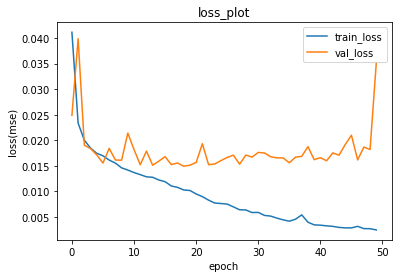

In [17]:
plt.plot(train_losses, label='train_loss') 
plt.plot(val_losses, label='val_loss') 
plt.xlabel('epoch') 
plt.ylabel('loss(mse)') 
plt.title('loss_plot') 

plt.show() 

# Inference

In [30]:
test = pd.DataFrame(bybit.fetch_ohlcv("BTCUSDT", timeframe="1h", limit=80))  
test_dates = test[0] 
test_timestamps = [] 
for i in range(len(test_dates)): 
    date_string = bybit.iso8601(int(test_dates[i]))  
    date_string = date_string[:10] + " " + date_string[11:-5] 
    test_timestamps.append(date_string) 
    
test['timestamp'] = test_timestamps 
test['timestamp'] = pd.to_datetime(test['timestamp'])
test

,0,1,2,3,4,5,timestamp
0,1635109200000,61186.0,61343.0,60852.0,61009.5,8.998808e+07,2021-10-24 21:00:00
1,1635112800000,61009.5,61103.5,60860.0,60957.5,3.615479e+07,2021-10-24 22:00:00
2,1635116400000,60957.5,60995.5,60752.0,60901.5,4.064861e+07,2021-10-24 23:00:00
3,1635120000000,60901.5,61840.0,60708.5,61827.5,1.381452e+08,2021-10-25 00:00:00
4,1635123600000,61827.5,62145.5,61730.0,61746.0,1.034869e+08,2021-10-25 01:00:00
...,...,...,...,...,...,...,...
75,1635379200000,58481.5,58917.5,58305.0,58327.0,8.970379e+07,2021-10-28 00:00:00
76,1635382800000,58327.0,59022.0,58144.0,58945.0,1.322635e+08,2021-10-28 01:00:00
77,1635386400000,58945.0,58945.0,58720.0,58940.0,2.747237e+07,2021-10-28 02:00:00
78,1635390000000,58940.0,59184.0,58739.0,58889.5,5.342441e+07,2021-10-28 03:00:00


In [31]:
window_size = 20 
future_size = 1 
test_enc_inputs = [] 
test_dec_inputs = [] 
test_targets = [] 
test_enc_marks = [] 
test_dec_marks = [] 

for i in tqdm(range(test.shape[0] - window_size - future_size), position=0, leave=True):  
    ### get enc_inputs, dec_inputs and targets ### 
    o = test[1].values[i:i+window_size+future_size] 
    h = test[2].values[i:i+window_size+future_size] 
    l = test[3].values[i:i+window_size+future_size] 
    c = test[4].values[i:i+window_size+future_size] 
    v = test[5].values[i:i+window_size+future_size] 
    
    o = (o - np.min(o)) / (np.max(o) - np.min(o)) 
    h = (h - np.min(h)) / (np.max(h) - np.min(h)) 
    l = (l - np.min(l)) / (np.max(l) - np.min(l)) 
    c = (c - np.min(c)) / (np.max(c) - np.min(c)) 
    v = v / np.max(v)  
    
    o_train = o[:window_size].reshape((-1,1)) 
    o_target = o[-1].reshape((-1,1)) 
    h_train = h[:window_size].reshape((-1,1))
    h_target = h[-1].reshape((-1,1)) 
    l_train = l[:window_size].reshape((-1,1)) 
    l_target = l[-1].reshape((-1,1)) 
    c_train = c[:window_size].reshape((-1,1)) 
    c_target = c[-1].reshape((-1,1)) 
    v_train = v[:window_size].reshape((-1,1)) 
    v_target = v[-1].reshape((-1,1)) 
    
    x = np.concatenate([o_train,h_train,l_train,c_train,v_train],axis=1) 
    y = np.concatenate([o_target,h_target,l_target,c_target,v_target],axis=1)
    y0 = np.zeros((1,5)) 

    test_enc_inputs.append(x) 
    test_dec_inputs.append(np.concatenate([x,y0], axis = 0)) 
    test_targets.append(y)  
    
    month = df['month'].values[i:i+window_size+future_size].reshape((-1,1)) 
    day = df['day'].values[i:i+window_size+future_size].reshape((-1,1))
    weekday = df['weekday'].values[i:i+window_size+future_size].reshape((-1,1))
    hour = df['hour'].values[i:i+window_size+future_size].reshape((-1,1))
        
    enc_dates = np.concatenate([month[:-1,:], day[:-1,:], weekday[:-1,:], hour[:-1,:]], axis=1)  
    test_enc_marks.append(enc_dates) 
    
    dec_dates = np.concatenate([month, day, weekday, hour], axis=1) 
    test_dec_marks.append(dec_dates) 
    

100%|██████████| 59/59 [00:00<00:00, 5376.85it/s]


In [32]:
test_enc_inputs = np.array(test_enc_inputs) 
test_dec_inputs = np.array(test_dec_inputs) 
test_targets = np.array(test_targets) 
test_enc_marks = np.array(test_enc_marks) 
test_dec_marks = np.array(test_dec_marks) 

test_enc_inputs.shape, test_dec_inputs.shape, test_targets.shape, test_enc_marks.shape, test_dec_marks.shape

((59, 20, 5), (59, 21, 5), (59, 1, 5), (59, 20, 4), (59, 21, 4))

In [78]:
test_dataset = CustomDataset(test_enc_inputs, 
                             test_dec_inputs, 
                             test_targets, 
                             test_enc_marks,
                             test_dec_marks) 
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)  

checkpoint = torch.load('btc_informer_stack_19_val_loss_0.014904952798546716') 
test_model = InformerStack(enc_in = 5, # encoder input size 
                           dec_in = 5, # decoder input size 
                           c_out = 5, # output size  
                           seq_len = window_size, # encoder sequence length 
                           label_len = window_size, # starter token length 
                           out_len = future_size, # output sequence length 
                           attn = 'prob') # use probsparse attention  
test_model.load_state_dict(checkpoint)
test_model.cuda() 
test_model.eval() # change to eval mode 
 
test_loss = 0 
correct = 0 
total_cnt = 0 
eps = 1e-10
for batch in test_dataloader: 
    encoder_input = batch['encoder_input'].to(device) 
    decoder_input = batch['decoder_input'].to(device) 
    target = batch['target'].to(device) 
    enc_marks = batch['encoder_marks'].to(device)  
    dec_marks = batch['decoder_marks'].to(device) 
    
    with torch.no_grad(): 
        outputs = test_model(x_enc=encoder_input,
                            x_mark_enc=enc_marks, 
                            x_dec=decoder_input, 
                            x_mark_dec=dec_marks) 
        loss = criterion(outputs, target) 
        test_loss += loss.item()   
        
        pred_y = outputs.detach().cpu().numpy()[:,:,0] 
        actual_y = target.detach().cpu().numpy()[:,:,0] 
        previous_y = encoder_input.detach().cpu().numpy()[:,-1,0].reshape((-1,1))
        
        for i in range(len(pred_y)): 
            if pred_y[i] >= previous_y[i] and actual_y[i] >= previous_y[i]: 
                correct += 1 
            elif pred_y[i] < previous_y[i] and actual_y[i] < previous_y[i]: 
                correct += 1 
            total_cnt += 1  
    
    
print("total loss = {:.4f}".format(test_loss)) 
print("correct = {}/{}".format(correct, total_cnt))  
print("accuracy = {:.4f}%".format(correct * 100 / total_cnt))

total loss = 0.0363
correct = 54/59
accuracy = 91.5254%
